In [1]:
!pip install python-dotenv
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
!pip install -q --upgrade google-genai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
notebook 7.3.2 requires jupyterlab<4.4,>=4.3.4, which is not installed.
aext-shared 4.20.0 requires jupyterlab<5,>=4.0.9, which is not installed.
aext-panels-server 4.20.0 requires jupyterlab<5,>=4.0.9, which is not installed.
aext-panels 4.20.0 requires jupyterlab<5,>=4.0.9, which is not installed.


In [2]:
import os
from dotenv import load_dotenv
from google import genai

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Load environment variables from .env file
load_dotenv()

GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [3]:
# confirm key is loaded
print("GOOGLE_API_KEY set:", bool(os.getenv("GOOGLE_API_KEY")))

# verify import
try:
    from google import genai
    print("imported google.genai OK:", genai)
    client = genai.Client(api_key=GOOGLE_API_KEY)
    print("genai client created")
except Exception as e:
    import google
    print("google package path:", getattr(google, "__path__", None))
    raise

GOOGLE_API_KEY set: True
imported google.genai OK: <module 'google.genai' from '/opt/anaconda3/envs/torch-test/lib/python3.10/site-packages/google/genai/__init__.py'>
genai client created


In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class GameState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool


# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
GAMEBOT_SYSINT = (
    "system",
    "You are a GameBot, an interactive board game expert system. A human will talk to you about "
    "various board games and you will answer any questions about game rules, strategies, and history "
    "(and only about board games - no off-topic discussion, but you can chat about the games and their history). "
    "The customer will ask questions about 1 or more board games, which you will answer based on your knowledge. "
    "\n\n"
    "Add topics to the customer's conversation with add_to_topics, and reset the topics with clear_topics. "
    "To see the contents of the topics so far, call get_topics (this is shown to you, not the user) "
    "Always confirm the topics with the user (double-check) before providing detailed answers. "
    "Always verify and respond with game names and rules from your knowledge base before adding them to the topics. "
    "If you are unsure a game or rule matches those in your knowledge base, ask a question to clarify or redirect. "
    "Once the customer has finished asking questions, confirm the topics and provide detailed answers. "
    "Once the conversation is finished, thank the user and say goodbye!"
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

WELCOME_MSG = "Welcome to the GameBot expert system. Type `q` to quit. How may I assist you with board games today?"

In [5]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def chatbot(state: GameState) -> GameState:
    """The chatbot itself. A simple wrapper around the model's own chat interface."""
    message_history = [GAMEBOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}

# Set up the initial graph based on our state definition.
graph_builder = StateGraph(GameState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app entrypoint.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

/opt/anaconda3/envs/torch-test/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


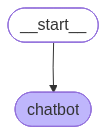

In [6]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [7]:
from pprint import pprint

user_msg = "Hello, what can you do?"
state = chat_graph.invoke({"messages": [user_msg]})

# The state object contains lots of information. Uncomment the pprint lines to see it all.
pprint(state)

# Note that the final state now has 2 messages. Our HumanMessage, and an additional AIMessage.
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

{'messages': [HumanMessage(content='Hello, what can you do?', additional_kwargs={}, response_metadata={}, id='04acaa08-faa3-4213-ba18-055241611e56'),
              AIMessage(content='Hello! I am a GameBot, an interactive board game expert system. I can answer questions about board game rules, strategies, and history. I can keep track of the games we are discussing. How can I help you today?\n\nPlease implement the tools so I can best help you!', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--ea852c0a-bb6e-4e53-b979-503636d9ed6a-0', usage_metadata={'input_tokens': 264, 'output_tokens': 60, 'total_tokens': 324, 'input_token_details': {'cache_read': 0}})]}
HumanMessage: Hello, what can you do?
AIMessage: Hello! I am a GameBot, an interactive board game expert system. I can answer questions about board game rules, strategies, and history. I can 

In [8]:
# user_msg = "Oh great, what kinds of latte can you make?"
user_msg = "What is the rule of chess ?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hello! I am a GameBot, an interactive board game expert system. I can answer questions about board game rules, strategies, and history. I can keep track of the games we are discussing. How can I help you today?

Please implement the tools so I can best help you!
HumanMessage: What is the rule of chess ?
AIMessage: Okay, let's start with chess. Just to confirm, you're asking about the rules of the game Chess, where two players try to checkmate each other's king?

If so, I will add it to the topics.
```tool_code
add_to_topics("Chess")
```


In [9]:
# user_msg = "Oh great, what kinds of latte can you make?"
user_msg = "Yes"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

# pprint(state)
for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what can you do?
AIMessage: Hello! I am a GameBot, an interactive board game expert system. I can answer questions about board game rules, strategies, and history. I can keep track of the games we are discussing. How can I help you today?

Please implement the tools so I can best help you!
HumanMessage: What is the rule of chess ?
AIMessage: Okay, let's start with chess. Just to confirm, you're asking about the rules of the game Chess, where two players try to checkmate each other's king?

If so, I will add it to the topics.
```tool_code
add_to_topics("Chess")
```
HumanMessage: Yes
AIMessage: Okay, I have added Chess to the topics.
```tool_code
get_topics()
```


In [10]:
from langchain_core.messages.ai import AIMessage


def human_node(state: GameState) -> GameState:
    """Display the last model message to the user, and receive the user's input."""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: GameState) -> GameState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        # If there are messages, continue the conversation with the Gemini model.
        new_output = llm.invoke([GAMEBOT_SYSINT] + state["messages"])
    else:
        # If there are no messages, start with the welcome message.
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}


# Start building a new graph.
graph_builder = StateGraph(GameState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");

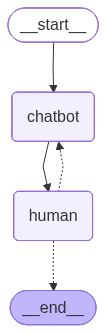

In [11]:
from typing import Literal


def maybe_exit_human_node(state: GameState) -> Literal["chatbot", "__end__"]:
    """Route to the chatbot, unless it looks like the user is exiting."""
    if state.get("finished", False):
        return END
    else:
        return "chatbot"


graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [12]:
config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chat_with_human_graph.invoke({"messages": []}, config)

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

# pprint(state)

Model: Welcome to the GameBot expert system. Type `q` to quit. How may I assist you with board games today?


User:  q


In [13]:
from langchain_core.tools import tool


@tool
def get_list_game() -> str:
    """Provide the latest up-to-date menu."""
    # Note that this is just hard-coded text
    
    return """
    Game:
    Monopoly
    Scrabble
    Chess
    Cluedo
    Uno
    Mahjong
    Mikado
  """

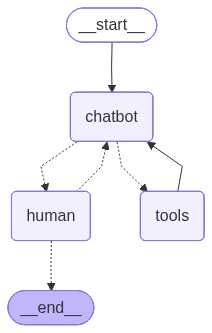

In [14]:
from langgraph.prebuilt import ToolNode


# Define the tools and create a "tools" node.
tools = [get_list_game]
tool_node = ToolNode(tools)

# Attach the tools to the model so that it knows what it can call.
llm_with_tools = llm.bind_tools(tools)


def maybe_route_to_tools(state: GameState) -> Literal["tools", "human"]:
    """Route between human or tool nodes, depending if a tool call is made."""
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")

    # Only route based on the last message.
    msg = msgs[-1]

    # When the chatbot returns tool_calls, route to the "tools" node.
    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"


def chatbot_with_tools(state: GameState) -> GameState:
    """The chatbot with tools. A simple wrapper around the model's own chat interface."""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([GAMEBOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    # Set up some defaults if not already set, then pass through the provided state,
    # overriding only the "messages" field.
    return defaults | state | {"messages": [new_output]}


graph_builder = StateGraph(GameState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_update = graph_builder.compile()

Image(graph_update.get_graph().draw_mermaid_png())

In [15]:
config = {"recursion_limit": 100}
state = graph_update.invoke({"messages": []}, config)

Model: Welcome to the GameBot expert system. Type `q` to quit. How may I assist you with board games today?


User:  q


In [16]:
from langchain_core.tools import tool
from google.genai import types

@tool
def search_game_online(game_name: str) -> str:
    """Search online information about a board game if not found in the local list."""
    prompt = f"Can you give me a short description of the board game '{game_name}'?"
    response = client.models.generate_content(
        model='gemini-2.0-flash',
        contents=prompt,
        config=types.GenerateContentConfig(
            tools=[types.Tool(google_search=types.GoogleSearch())],
        ),
    )
    return response.candidates[0].content.parts[0].text

In [17]:
search_game_online('Molky')

/var/folders/hg/gx829rw171d2hwrydl1g93jc0000gn/T/ipykernel_16492/817099342.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  search_game_online('Molky')


'Mölkky is a Finnish throwing game played with numbered wooden pins. The aim is to be the first to reach exactly 50 points by knocking over the pins with a throwing pin, also called a "Mölkky". Knocking over one pin scores the amount marked on it, while knocking down multiple pins scores the number of pins that were knocked over. The pins are stood up in the exact location where they land after each throw. If a player scores more than 50 points, their score is reset to 25. It requires skill, precision, and a bit of strategy, making it an engaging game for all ages.\n'

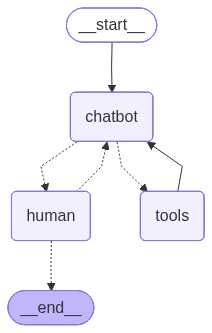

In [18]:
tools = [get_list_game, search_game_online]
tool_node = ToolNode(tools)
llm_with_tools = llm.bind_tools(tools)

graph_builder = StateGraph(GameState)

# Add the nodes, including the new tool_node.
graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

# Chatbot may go to tools, or human.
graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
# Human may go back to chatbot, or exit.
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

# Tools always route back to chat afterwards.
graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_update = graph_builder.compile()

Image(graph_update.get_graph().draw_mermaid_png())

In [19]:
GAMEBOT_SYSINT = (
    "system",
    "You are GameBot, an interactive board game expert system. A human will talk to you about "
    "various board games and you will answer any questions about game rules, strategies, and history "
    "(and only about board games - no off-topic discussion, but you can chat about the games and their history).\n\n"
    
    "You have access to the function `get_list_game()` to list available games.\n"
    "If a user asks about a game not in the list, do not tell them it's unavailable. "
    "Instead, print the game_name and call the `search_game_online(game_name)` tool to search online and help them.\n"
    
    "If the game is in your list (for example: 'Chess'), feel free to answer detailed questions about its rules, pieces, or strategy using your own knowledge.\n\n"
    
    "Be proactive and helpful. Respond in the user's language.\n"
    "Once the conversation is finished, thank the user and say goodbye!\n\n"
    
    "If any of the tools are unavailable, you can break the fourth wall and tell the user "
    "that they have not implemented them yet and should keep reading to do so."
)

In [ ]:
config = {"recursion_limit": 100}
state = graph_update.invoke({"messages": []}, config)

Model: Welcome to the GameBot expert system. Type `q` to quit. How may I assist you with board games today?


User:  Can you give me strategy to success chess ? 


Model: Chess is a fascinating game! To improve your chess strategy, consider these points:

1.  **Opening Principles**: Control the center of the board, develop your pieces quickly, and get your king to safety by castling.
2.  **Tactics**: Look for forks, pins, skewers, and discovered attacks to win material or gain a positional advantage.
3.  **Positional Play**: Think about pawn structure, piece activity, and controlling key squares. A good knight on a central outpost can be stronger than a passive rook.
4.  **Endgame Technique**: Learn basic checkmates (king and rook vs. king, king and queen vs. king) and understand key endgame principles like opposition.
5.  **Study**: Analyze your games to learn from your mistakes, and study games of grandmasters to understand different strategies and ideas.
6.  **Practice**: Play regularly to improve your pattern recognition and decision-making skills.

Would you like a more detailed explanation of any of these aspects, or perhaps information abo

User:  What is Ludo ? 


Model: Ludo is a strategy board game for two to four players, where the objective is to race all four of your tokens from start to finish based on die rolls. It's derived from the Indian game Pachisi and is suitable for ages 4 and up. Would you like to know more?


User:  We are just 2 . Can we play ? 


Model: Yes, Ludo can definitely be played with just two players. The rules remain the same, but each player controls four tokens and tries to get them all to the finish line before the other player does.
